### Modeling Strategies Assignment 8 & Supervised ML

### Mortgage Default Risk & Fraud Detection

### Author: Chloe Du (jd3631)

#### Part 1: Review the data

In [1]:
#import necessary libraries
import numpy as np 
import pandas as pd

from scipy import stats  #for some statistics
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline

import warnings 
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn  #ignore warnings (from sklearn and seaborn)

There are 80,000 distinct mortgage loan applicants and there are 89 different features.

There are many missing data in the whole dataset. We will deal with these missing values later.

The most common operation used when applying for loan is h5, and the most comman mobile brand used is web.

The target value is loan_default. This indicates if a client will default mortage loan in the future. As the value 0 for default payment means not default and value 1 means default, the mean of 0.1936 means that there are 19.36% of mortgage loan contracts that will default (will verify this in the next sections of this analysis).

We will explore in more detail the data in the following section.

In [2]:
# Now to import and put the dataset 
df = pd.read_csv("/Users/jiayangdu/Desktop/Columbia University /APAN 5420/XYZloan_default_selected_vars.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,3,4,4,0,34,2,4,12,2017/7/7 10:10,android,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,4,5,5,0,47,2,1,12,2017/7/6 14:37,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [3]:
##adjust the varibles, drop meaningless variables
df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [4]:
#id has no meaning of value, so we convert it to categorical variables
df['id'] = df['id'].apply(lambda x:str(x))
#AP005 represents the datetime, so we need to convert it to datetime type
df['AP005'] = pd.to_datetime(df['AP005'])

df.info()
#there are some missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 87 columns):
id              80000 non-null object
loan_default    80000 non-null int64
AP001           80000 non-null int64
AP002           80000 non-null int64
AP003           80000 non-null int64
AP004           80000 non-null int64
AP005           80000 non-null datetime64[ns]
AP006           80000 non-null object
AP007           80000 non-null int64
AP008           80000 non-null int64
AP009           80000 non-null int64
TD001           80000 non-null int64
TD002           80000 non-null int64
TD005           80000 non-null int64
TD006           80000 non-null int64
TD009           80000 non-null int64
TD010           80000 non-null int64
TD013           80000 non-null int64
TD014           80000 non-null int64
TD015           80000 non-null int64
TD022           60402 non-null float64
TD023           72337 non-null float64
TD024           76306 non-null float64
TD025           77450 n

In [5]:
#replace -1,-99,-98,-999 to na, since these two strange values may be systematic default value
df.replace('-99',' ',inplace=True)
df.replace('-98',' ',inplace=True)
df.replace('-999',' ',inplace=True)
df.replace('-1',' ',inplace=True)

In [6]:
#missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
TD055,79999,0.999988
TD062,79999,0.999988
TD048,79999,0.999988
TD044,79997,0.999962
TD051,79995,0.999938
TD061,79990,0.999875
TD054,79988,0.999850
TD022,19598,0.244975
TD023,7663,0.095787
TD024,3694,0.046175


In [7]:
#from the above dataframe, we can see that there are some variables missing almost 100% values
#therefore, i will drop those variables which lose up to 99% values
df.drop(['TD055','TD062','TD048','TD044','TD051','TD061','TD054'],axis=1,inplace=True)
# for other columns containing missing values, we do not need to deal with them
# since in the following steps, we will bin some variables and missing values will be regarded as their own categories
# the tree-based algorithms will capture the information from nah values

outliers:

Since we will use tree-based algorithems which treat continuous variable as categorical variable as well, so the these modles are not sensitive to outliers at all and we do not need to cap or floor outliers here.

In [8]:
#get statistics info about numerical variables
df.describe()

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,...,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,...,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,77207.000000
mean,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,0.706213,...,6.911956,14.271694,11.773358,909.089313,810.786219,1732.693314,1539.33443,2513.226491,2229.606137,5.976272
std,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,0.918347,...,28.007499,38.235012,33.270641,1379.553332,1245.044602,2441.503517,2172.71384,3404.975112,3005.615048,3.641814
min,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,0.000000
25%,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,0.000000,...,2.000000,5.000000,4.000000,84.000000,34.000000,309.000000,226.00000,539.000000,414.000000,3.000000
50%,0.000000,30.000000,1.000000,1.000000,12.000000,3.00000,3.000000,1.000000,2.000000,0.000000,...,7.000000,12.000000,10.000000,475.000000,397.000000,1023.000000,870.00000,1553.000000,1324.000000,5.000000
75%,0.000000,35.000000,2.000000,3.000000,12.000000,5.00000,4.000000,1.000000,3.000000,1.000000,...,14.000000,23.000000,20.000000,1209.000000,1080.000000,2287.000000,2030.00000,3296.000000,2936.000000,8.000000
max,1.000000,56.000000,2.000000,6.000000,12.000000,5.00000,5.000000,1.000000,20.000000,11.000000,...,1061.000000,2792.000000,1579.000000,48585.000000,29664.000000,88364.000000,54651.00000,125352.000000,87312.000000,47.000000


In [9]:
#Take a quick look at some basic categorical data
df.describe(include=['O'])
#we can see there is no duplicate applicants 
#h5 is the most common operation system 
#web is the most common operation device

,id,AP006,MB007
count,80000,80000,80000
unique,80000,4,112
top,30967,h5,WEB
freq,1,44246,43850


###### Explore the data

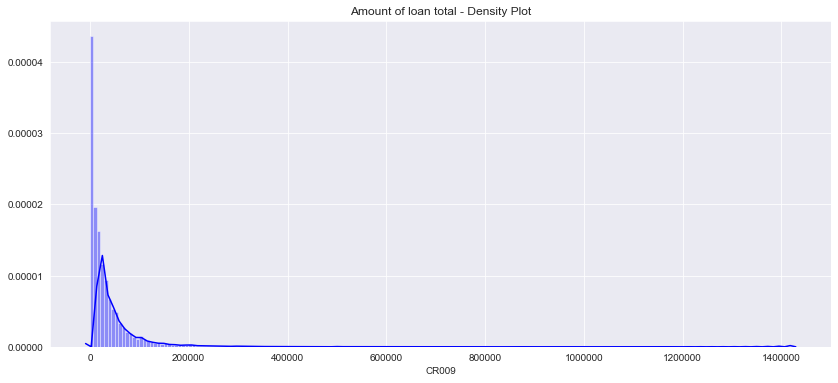

In [10]:
#Amount of loan total
plt.figure(figsize = (14,6))
plt.title('Amount of loan total - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(df['CR009'],kde=True,bins=200,color="blue")
plt.show()
# There are many missing values in this field
#Largest group of amount of credit limit is apparently for amount of 5k. 
#Let's verify this.

In [11]:
df['CR009'].value_counts().shape
#There are 25,883 distinct values for amount of loan total.

(25883,)

In [12]:
df['CR009'].value_counts().head(5)
#Indeed, the largest number of credit cards are with limit of:
#5k (1035), followed by:
#10k (934) and
#2k (674) and 20k (671).

0        13245
5000      1035
10000      934
2000       674
20000      671
Name: CR009, dtype: int64

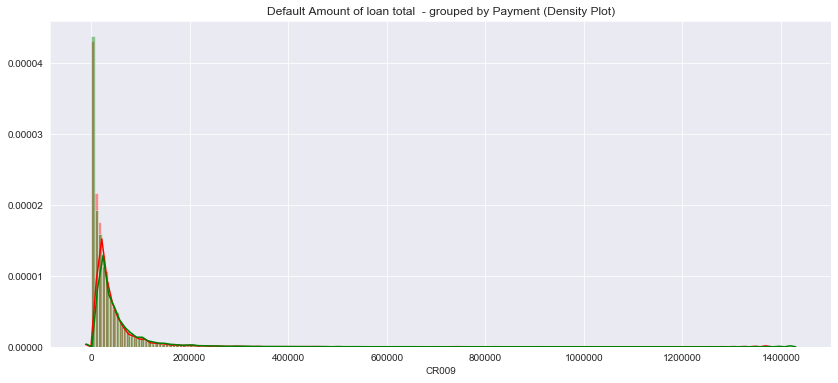

In [13]:
#Amount of credit limit grouped by default payment
class_0 = df.loc[df['loan_default'] == 0]["CR009"]
class_1 = df.loc[df['loan_default'] == 1]["CR009"]
plt.figure(figsize = (14,6))
plt.title('Default Amount of loan total  - grouped by Payment (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()
#Most of defaults are for loan amount 0-20k (and density for this interval is larger for defaults than for non-defaults).
#Larger defaults number are for the amounts of 5k, 20k.

#### Part 2: feature construct

##### datetime variable

In [14]:
#we cannot employ any DateTime field of the yymmdd:hhmmss format in any tree-based methods. 
# derive year, month, day, weekday, etc. from this field.
df = df.assign(hour=df.AP005.dt.hour,
               day=df.AP005.dt.day,
               month=df.AP005.dt.month,
               year=df.AP005.dt.year)

In [15]:
df['DayofWeek']=df['AP005'].apply(lambda x:x.dayofweek)

##### categorical variable

In [16]:
## Get_Dummy for One-Hot #
#AP006 operation system
dummies = pd.get_dummies(df['AP006'],dummy_na=True)
df = pd.concat([df, dummies], axis=1)

In [17]:
#MB007 device
dummies2 = pd.get_dummies(df['MB007'],dummy_na=True)
df = pd.concat([df, dummies2], axis=1)
#since we are running  tree-based algorithms, 
#so there is no need to drop the variable

In [18]:
#Ap002 gender
# in oreder to standardlize, 
# change 1 to 0, 2 to 1
df['AP002'] = df['AP002'] - 1

In [19]:
#AP003 education level, dummy it 
df['AP003'] = df['AP003'].apply(lambda x:'education'+str(x))
dummies3 = pd.get_dummies(df['AP003'],dummy_na=True)
df = pd.concat([df, dummies3], axis=1)

##### Numerical Variables

In [20]:
###create a new dataframe onlu containing the numerical varibles
###make it easier for the following steps (binning continuous variables)
numerical_columns = ['MB005','CD173','CD172','CD170','CD169','CD167','CD166',
                 'CD164','CD162','CD160','CD153','CD152','CD137','CD136',
                 'CD135','CD133','CD132','CD131','CD130','CD123','CD121',
                 'CD120','CD118','CD117','CD115','CD114','CD113','CD108',
                 'CD107','CD106','CD101','CD100','CD088','CD072','CD071',
                 'CD018','CD008','PA031','PA030','PA029','PA028','PA023',
                 'PA022','CR019','CR018','CR017','CR015','CR012','CR009','CR005',
                 'CR004','TD029','TD028','TD027','TD026','TD025','TD024','TD023',
                 'TD022','TD015','TD014','TD013','TD010','TD009','TD006','TD005',
                 'TD002','TD001','AP004']

In [21]:
for col in numerical_columns:
    df[col] = pd.qcut(df[col],10,duplicates='drop',labels=False)

##### drop unwanted columns

In [22]:
df.drop(['AP005','AP006','MB007','AP003'],axis=1,inplace=True)

##### check missing values again

In [23]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
TD025,80000,1.000000
TD027,80000,1.000000
TD028,80000,1.000000
TD029,80000,1.000000
CR012,80000,1.000000
TD026,80000,1.000000
TD022,19598,0.244975
TD023,7663,0.095787
TD024,3694,0.046175
MB005,2793,0.034912


In [24]:
# then we should notice variable 'TD025,026,027,028,029' and 'CR012' are 100% missing values, 
# when we look into these variables, we could find they do not carry any important information
# because they only have 1 value (0) across the whole data set.
# Therefore, I will drop them as well
df.drop(['TD025','TD027','TD028','TD029','TD026','CR012'],axis=1,inplace=True)

In [25]:
# for other missing values, 
# We uniformly replace them with -1
df.fillna(-1,inplace=True)

In [26]:
#drop columns named Nan
df = df.loc[:, df.columns.notnull()]

#### Part 3: Target Variable

 Note: our target variable is "loan_default", so we have a logistic problem (0 or 1)

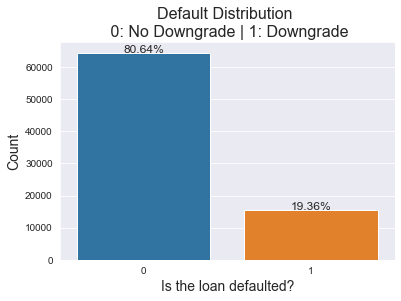

In [27]:
#Visulization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plot_tr = sns.countplot(x='loan_default', data=df)
plot_tr.set_title("Default Distribution \n 0: No Downgrade | 1: Downgrade", fontsize=16)
plot_tr.set_xlabel("Is the loan defaulted?", fontsize=14)
plot_tr.set_ylabel('Count', fontsize=14)
total = len(df)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

#### Part 4: Variable Importance

Since tree-based model is very lazy, there is no need to worry about the interaction between factors, so we can use as many as possible factors here (the good ones will be picked out by model automatically, and the bad ones will be kicked out directly). We don't need to worry about the correlation between factors.

In [28]:
#classify variables
var = pd.DataFrame(df.dtypes)
var = pd.DataFrame(df.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
var['source'].value_counts()

CD    36
IP    13
TD    12
CR     7
AP     7
      ..
FO     1
da     1
HR     1
HI     1
EY     1
Name: source, Length: 92, dtype: int64

In [29]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
#Aplist remove 'apple'
AP_list.remove('APPLE')
# other remaining variables to get a dummy list
dummy_list = list(set(list(df.columns)).difference(set(MB_list+AP_list+TD_list+CR_list+PA_list+CD_list)))
dummy_list.remove('id')

In [30]:
predictors = MB_list + TD_list + AP_list + CD_list + CR_list + PA_list + dummy_list
target='loan_default'

In [31]:
def VarImp(model_name):
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

#### Part 5: Define Evaluation Index

In [32]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
##check confusion_matrix
def confusion_matrix(pred,real):
    x = pd.DataFrame()
    x['label'] = real
    x['predict'] = pred

    TruePositive = sum(x[x['predict']==1]['label'])
    FalsePositive = sum(1-x[x['predict']==1]['label'])
    TrueNegative = sum(1-x[x['predict']==0]['label'])
    FalseNegative = sum(x[x['predict']==0]['label'])

    Precision = TruePositive/(TruePositive+FalsePositive)
    Recall = TruePositive/(TruePositive+FalseNegative)
    print('\nPrecision: {}'.format(Precision))
    print('Recall: {}\n'.format(Recall))
    _confusion_matrix = pd.DataFrame({
                    'Negative':{'False':FalseNegative,'True':TrueNegative},
                    'Positive':{'False':FalsePositive,'True':TruePositive}                            
                    })      
    
    print(_confusion_matrix)
    return _confusion_matrix

In [33]:
def ROC_AUC(my_result,df,target):

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,threshold = roc_curve(y_actual,y_pred) ###Calculate the true positive rate and the false positive rate
    roc_auc = auc(fpr,tpr) ###calculate auc
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC curve
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (area=%0.2f)' % roc_auc) ###The false positive rate is the abscissa, and the true rate is the ordinate
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall curve
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

In [34]:
###create gains table
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

#### Part 6: Undersampling

In [35]:
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.decomposition import PCA
import pylab as pl
def plot_this(X_rs,y_rs,method):
    # Use principal component to condense the 10 features to 2 features
    pca = PCA(n_components=2).fit(X_rs)
    pca_2d = pca.transform(X_rs)
    # Assign colors
    for i in range(0, pca_2d.shape[0]):
        if y_rs[i] == 0:
            c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='o')
        elif y_rs[i] == 1:
            c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='*')  
    #plt.legend([c1, c2], ['Class 1', 'Class 2']
    #plt.title(method)
    #pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
    plt.show()

Random undersampling Counter({0: 15488, 1: 15488})


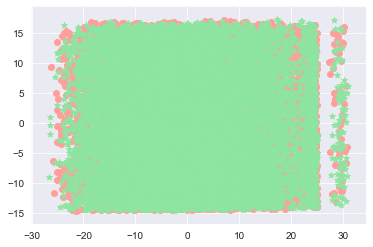

In [67]:
## here i will try RandomUnderSampler
from collections import Counter
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)
X = df[predictors]
y = df[target]

# RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
X_rs, y_rs = sampler.fit_sample(X, y)
print('Random undersampling {}'.format(Counter(y_rs)))
plot_this(X_rs,y_rs,'Random undersampling')

#### Part 7: Modelling

In [38]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tt/c8c74ptx7hd3ln9pgn4ych_h0000gn/T/tmpwqdwbayn
  JVM stdout: /var/folders/tt/c8c74ptx7hd3ln9pgn4ych_h0000gn/T/tmpwqdwbayn/h2o_jiayangdu_started_from_python.out
  JVM stderr: /var/folders/tt/c8c74ptx7hd3ln9pgn4ych_h0000gn/T/tmpwqdwbayn/h2o_jiayangdu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.7
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_jiayangdu_im6x76
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [39]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [40]:
y_rs = y_rs.to_frame()

In [41]:
#concatenate X_rs and y_rs to a data frame
df = pd.concat([X_rs, y_rs])
df = df.dropna()

##### Model1: Random Forest

In [87]:
#train test split 7:3
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.30, random_state=42)

In [88]:
#try small sample dataset to run model first
#convert to a H2O data frame 
from h2o.frame import H2OFrame
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [89]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


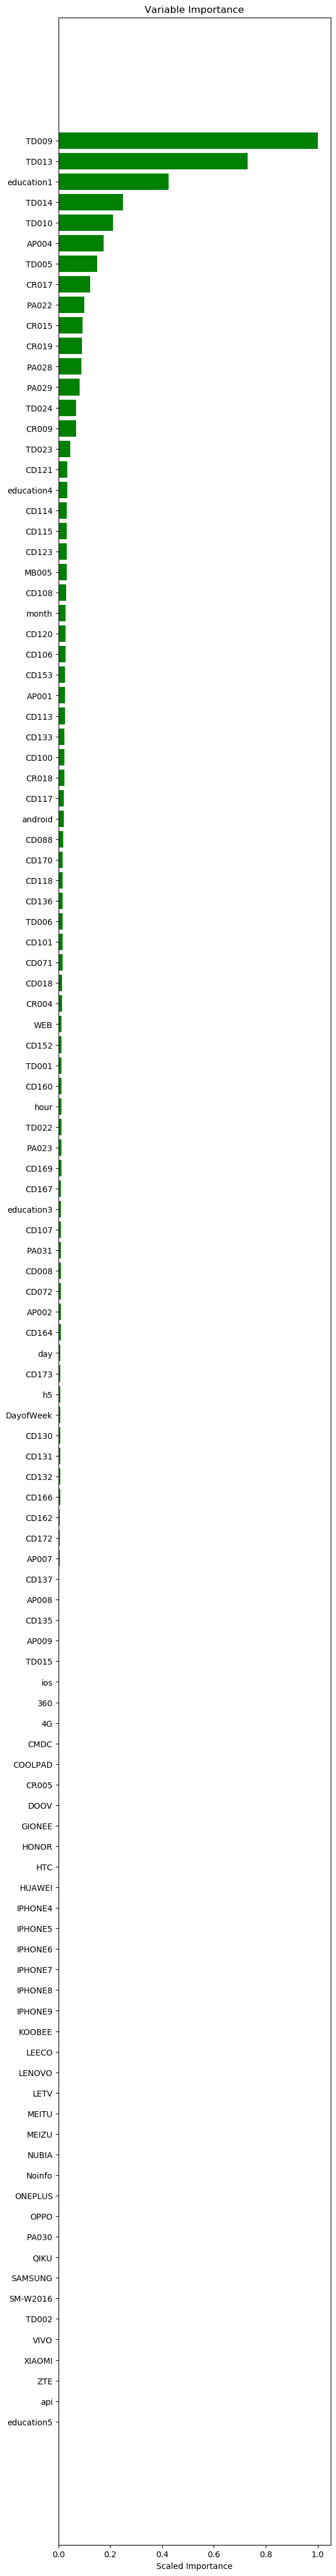

In [90]:
#check the variable importance 
VarImp(rf_v1)

In [91]:
predictions = rf_v1.predict(test_hex)
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,predict
0,1,0.584776
1,0,0.337304
2,0,0.483436
3,0,0.518015
4,1,0.640596


###### Model 1 RF evaluation

drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



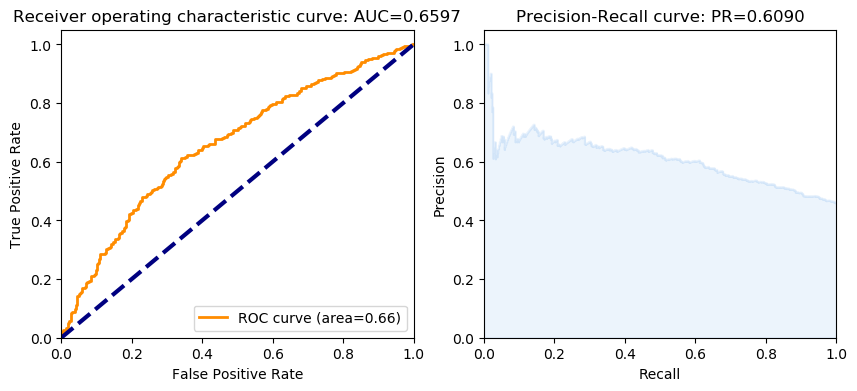

In [92]:
ROC_AUC(rf_v1,test_hex,'loan_default')

from the above figures, we can see that the model performance is not ideal with a low value of ROC.

###### Parameter Tuning

In [93]:
###########Define the grid parameters###########
from h2o.grid.grid_search import H2OGridSearch
estimator = H2ORandomForestEstimator(
    # Stops fitting new trees when 5-tree rolling average is within 1e-4
    stopping_rounds = 10,
    stopping_tolerance = 0.00001,
    stopping_metric = 'auto',
    score_each_iteration = True,
    balance_classes = True,
    seed = 7)

hyper_parameters = {'ntrees':[10,20,30,40,50,100,200,300,500,600,700,800,900,1000,1500,2000], 
                    'max_depth':[2,3,5,6,7,8,9,10,12,15,20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
                   }

criteria = {"strategy": "RandomDiscrete", 
            "stopping_rounds": 10,
            "stopping_tolerance": 0.00001,
            "stopping_metric": "misclassification"}

grid_search = H2OGridSearch(model = estimator, 
                            hyper_params = hyper_parameters,
                            search_criteria = criteria)

In [110]:
#Now train the network
grid_search.train(x = predictors,
                  y = target,
                  training_frame = train_hex)
#Sort the grid models by increasing rmse 
#the smaller the rmse is, the better the model performed
sorted_grid = grid_search.get_grid(sort_by='rmse',decreasing=False)
# print('Best model sorted by auc:\n', sorted_grid.models[0])

best_max_depth  = sorted_grid.sorted_metric_table()['max_depth'][0]
best_ntrees     = sorted_grid.sorted_metric_table()['ntrees'][0]
#best_auc        = sorted_grid.sorted_metric_table()['auc'][0]
#sorted_grid_mse = grid_search.get_grid(sort_by='mse',decreasing=True)
best_rmse        = sorted_grid.sorted_metric_table()['rmse'][0]

print('Best max_depth.....', best_max_depth)
print('Best ntrees........', best_ntrees)
#print('Best auc...........', best_auc)
print('Best rmse...........', best_mse)

Best max_depth..... 7
Best ntrees........ 900
Best rmse........... 0.15632192378921017


In [94]:
best_rf = H2ORandomForestEstimator(
    model_id = "best_rf",
    ntrees = 900,
    max_depth = 7,
    nfolds= 5,
    min_rows=100,
    #stopping_rounds = 10,
    #score_each_iteration = True,
    seed = 7)

best_rf.train(predictors, 
              target, 
              training_frame = train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [95]:
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)
RF_actual_predict = actual_predict(best_rf,test_hex,target)
RF_actual_predict.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


,actual,pred
0,1,0.571524
1,0,0.323420
2,0,0.472834
3,0,0.528981
4,1,0.651204


In [96]:
# ROC
from sklearn.metrics import roc_auc_score
rf_roc_auc_value = roc_auc_score(RF_actual_predict['actual'],RF_actual_predict['pred'])
rf_roc_auc_value

0.6575990068975817

There is no large improvement on the performance of my model, so i guess we could increase the accuracy through random oversampling or adjusting some of criterias.

###### Now the code works fine with the small dataset, we can model with the entire dataset

In [97]:
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [98]:
rf_v2 = H2ORandomForestEstimator(
        model_id = 'RF',
        ntrees = 900,
        nfolds=10,
        min_rows=100,
        seed=7)

rf_v2.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [99]:
# put together the actual and predicted values
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)
RF_actual_predict = actual_predict(rf_v2,test_hex,target)
RF_actual_predict.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


,actual,pred
0,1,0.472194
1,0,0.515944
2,0,0.558297
3,0,0.310929
4,0,0.418860


###### Evaluate again

drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



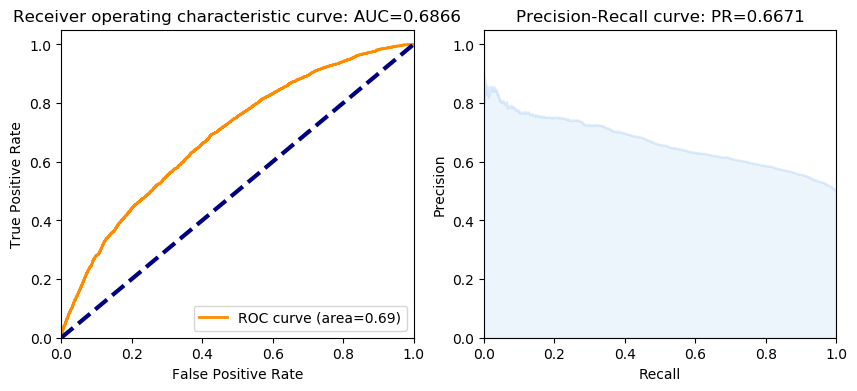

In [100]:
ROC_AUC(rf_v2,test_hex,'loan_default')

In [101]:
createGains(rf_v2)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,930,703,227,930,703,227,0.15,0.05,460.6,1.53,10.0,75.59
1,929,644,285,1859,1347,512,0.29,0.11,921.2,1.46,18.0,72.46
2,929,576,353,2788,1923,865,0.42,0.18,1381.8,1.39,24.0,68.97
3,930,493,437,3718,2416,1302,0.52,0.28,1842.4,1.31,24.0,64.98
4,929,493,436,4647,2909,1738,0.63,0.37,2303.0,1.26,26.0,62.60
5,929,451,478,5576,3360,2216,0.73,0.47,2763.6,1.22,26.0,60.26
6,930,420,510,6506,3780,2726,0.82,0.58,3224.2,1.17,24.0,58.10
7,929,352,577,7435,4132,3303,0.90,0.70,3684.8,1.12,20.0,55.57
8,929,296,633,8364,4428,3936,0.96,0.84,4145.4,1.07,12.0,52.94


we could notice that to 6th decile, we can access to up tp 80% of applicants who actually default the loan, but in the predictive model we could access to such large group of defaluters in 9th decile. 

##### Model 2: Gradient Boosting Machine (GBM) 

In [42]:
#Let's start by spliting the data in train, validation and test sets. 
#We will use 60%, 20% and 20% splits.
#Split the data
train_df, valid_df, test_df = np.split(df, [int(.6*len(df)), int(.8*len(df))])
print("Number of rows in train, valid and test set : ", train_df.shape[0], valid_df.shape[0], test_df.shape[0])

Number of rows in train, valid and test set :  18585 6195 6196


In [43]:
train_hex = h2o.H2OFrame(train_df)
test_hex = h2o.H2OFrame(test_df)
valid_hex = h2o.H2OFrame(valid_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [44]:
####train gbm
# initialize the H2O GBM
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        seed=1234)
# train with the initialized model
gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


###### GBM Model evaluation

In [45]:
#Let's inspect the model already trained. We can print the summary:
gbm_v1.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,21675.0,5.0,5.0,5.0,23.0,32.0,29.8


This shows that we used 50 trees, 50 internal trees. It is also showing the min and max tree depth (5,5), the min and max number of leaves (23,32) and the mean values for tree depth and number of leaves, 30.82.

We can also inspect the model further, looking to other informations.

Let's see the model performance for the train set.

In [46]:
print(gbm_v1.model_performance(train_hex))


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.11637951518130552
RMSE: 0.3411444198302319
MAE: 0.24661700441079287
RMSLE: 0.23729084442854714
Mean Residual Deviance: 0.11637951518130552



gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



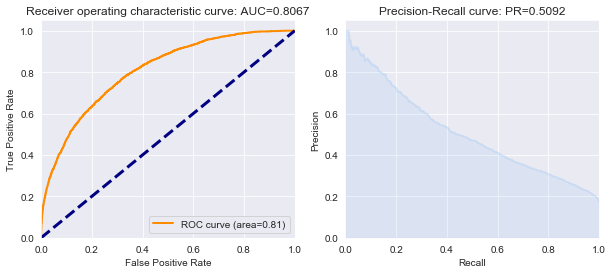

In [47]:
ROC_AUC(gbm_v1,train_hex,'loan_default')

For the train set, the RMSE obtained is 0.37, the AUC score is 0.75. Mean Residual Deviance is 0.13.

Let's check now the performance of the model with the validation set.

In [48]:
print(gbm_v1.model_performance(valid_hex))


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.6217515404795042
RMSE: 0.7885122322954187
MAE: 0.7828043143881321
RMSLE: 0.5054007034394856
Mean Residual Deviance: 0.6217515404795042



gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



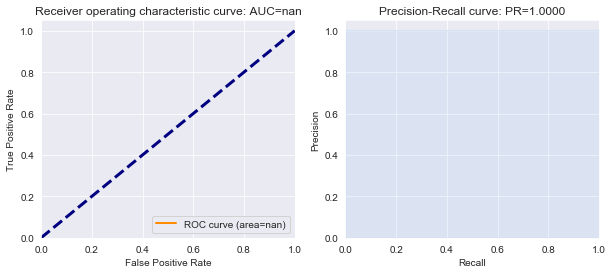

In [49]:
ROC_AUC(gbm_v1,valid_hex,'loan_default')

In [50]:
createGains(gbm_v1)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,620,620,0,620,620,0,0.1,NaN,619.6,1.0,NaN,100.0
1,620,620,0,1240,1240,0,0.2,NaN,1239.2,1.0,NaN,100.0
2,619,619,0,1859,1859,0,0.3,NaN,1858.8,1.0,NaN,100.0
3,620,620,0,2479,2479,0,0.4,NaN,2478.4,1.0,NaN,100.0
4,619,619,0,3098,3098,0,0.5,NaN,3098.0,1.0,NaN,100.0
5,620,620,0,3718,3718,0,0.6,NaN,3717.6,1.0,NaN,100.0
6,620,620,0,4338,4338,0,0.7,NaN,4337.2,1.0,NaN,100.0
7,619,619,0,4957,4957,0,0.8,NaN,4956.8,1.0,NaN,100.0
8,620,620,0,5577,5577,0,0.9,NaN,5576.4,1.0,NaN,100.0


For the validation set, the RMSE obtained is 0.37, the AUC score is 0.69. Mean Residual Deviance is 0.14.

To summarize, we obtained AUC score 0.75 for train set and 0.69 for test set.

Let's use the validation set to tune the parameters.

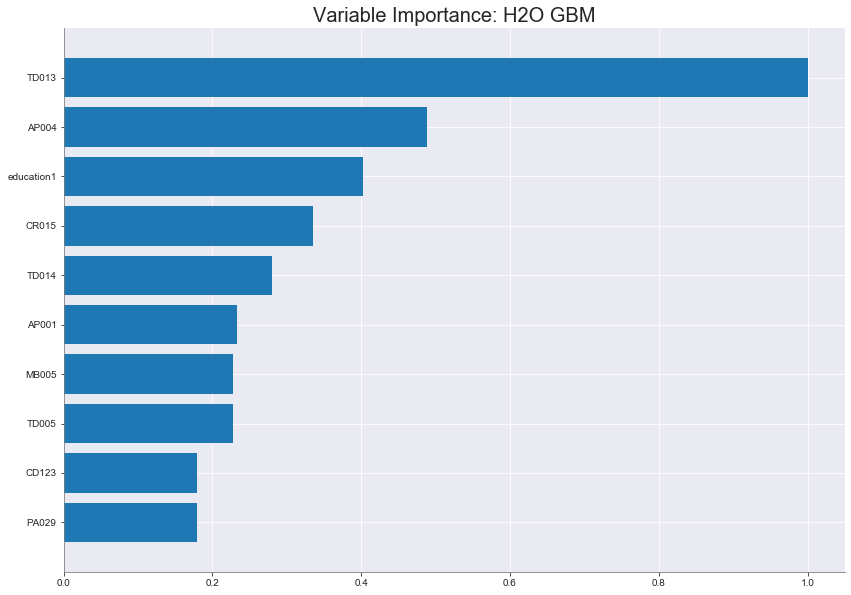

In [51]:
gbm_v1.varimp_plot()

##### Parameters tuning

In [ ]:
##here the reason i chose rmse is that my h2o is a little bit old and there is no auc metrics by default
tuned_gbm  = H2OGradientBoostingEstimator(
    ntrees = 1000,
    learn_rate = 0.05,
    stopping_rounds = 25,
    stopping_metric = "RMSE",
    col_sample_rate = 0.65,
    sample_rate = 0.65,
    seed = 1234
)      
tuned_gbm.train(x=predictors, y=target, training_frame=train_hex, validation_frame=valid_hex)

gbm Model Build progress: |████████████████████

RMSE: 0.37939915532996354
gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



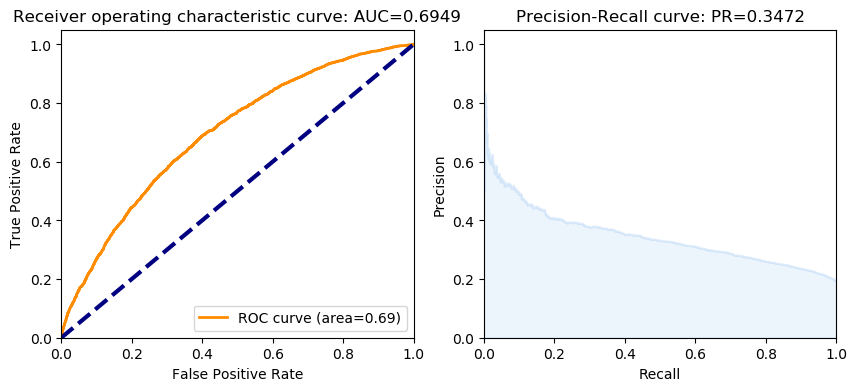

In [53]:
print("RMSE:",tuned_gbm.model_performance(valid_hex).rmse())
ROC_AUC(gbm_v1,valid_hex,'loan_default')

The performance was not improved (AUC did not change).

In [54]:
###########Grid Search Tuning###########
#Use small sample set to tune parameters to make the grid search run faster
train_sam, validate_sam, test_sam = np.split(df.sample(frac=0.1), [int(.6*len(df.sample(frac=0.1))), int(.8*len(df.sample(frac=0.1)))])
train_sam_hex = h2o.H2OFrame(train_sam)
test_sam_hex = h2o.H2OFrame(test_sam)
valid_sam_hex = h2o.H2OFrame(validate_sam)
print("Number of rows in train, valid and test set : ", train_sam.shape[0], validate_sam.shape[0], test_sam.shape[0])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Number of rows in train, valid and test set :  4800 1600 1600


In [55]:
#Define the grid parameters
from h2o.grid.grid_search import H2OGridSearch
grid_search_gbm = H2OGradientBoostingEstimator(
    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
    #10 consecutive scoring events
    stopping_rounds = 10,
    stopping_metric = "AUTO",
    ## sample 80% of columns per split
    col_sample_rate = 0.65,
    ## sample 80% of rows per tree
    sample_rate = 0.65,
    stopping_tolerance = 0.00001,
    score_each_iteration = True,
    balance_classes = True,
    seed = 1234,
    ## score every 10 trees to make early stopping reproducible 
    #(it depends on the scoring interval)
    score_tree_interval = 10
) 

hyper_params = {
    'learn_rate':[0.01, 0.02, 0.03, 0.05,0.07,0.8,0.9,0.1],
    'max_depth':[4,5,6,7,8,9,10,12,15,24],
    'ntrees':[10,20,40, 50,100,150, 250, 500, 700, 1000,1500,2000]}

grid = H2OGridSearch(grid_search_gbm, hyper_params,
                         grid_id='depth_grid',
                         search_criteria={'strategy': "Cartesian"})

In [56]:
#Train grid search
grid.train(x=predictors, 
           y=target,
           training_frame=train_sam_hex,
           validation_frame=valid_sam_hex)
#We will explore the model, printing the parameters which give the best rmse.
grid_sorted = grid.get_grid(sort_by='rmse',decreasing=False)
print(grid_sorted)

       learn_rate max_depth ntrees             model_ids                 rmse
0            0.02         4   1000  depth_grid_model_130   0.3749217676250993
1            0.02         4    250   depth_grid_model_34   0.3749217676250993
2            0.02         4    500   depth_grid_model_66   0.3749217676250993
3            0.02         4    700   depth_grid_model_98   0.3749217676250993
4            0.01         4   1000  depth_grid_model_129  0.37540391288418445
..  ..        ...       ...    ...                   ...                  ...
155           0.9        24    700  depth_grid_model_127   0.7002057521163736
156           0.9        24   1000  depth_grid_model_159   0.7002057521163736
157           0.9        24     50   depth_grid_model_31   0.7002057521163736
158           0.9        24    250   depth_grid_model_63   0.7002057521163736
159           0.9        24    500   depth_grid_model_95   0.7002057521163736

[160 rows x 6 columns]



In [57]:
#Let's pick the best model, selected by AUC:

best_gbm = grid_sorted.models[0]
print(best_gbm)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  depth_grid_model_130


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,162.0,162.0,40736.0,4.0,4.0,4.0,12.0,16.0,15.37037




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.1308723782905666
RMSE: 0.36176287577716787
MAE: 0.28064541974056434
RMSLE: 0.25154646533723707
Mean Residual Deviance: 0.1308723782905666

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.14056633183912898
RMSE: 0.3749217676250993
MAE: 0.291098735352342
RMSLE: 0.26469051693829837
Mean Residual Deviance: 0.14056633183912898

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-07-24 11:58:17,3 min 2.791 sec,0.0,0.399374,0.318999,0.159499,0.386615,0.308971,0.149472
1,,2020-07-24 11:58:17,3 min 2.816 sec,1.0,0.398907,0.318672,0.159127,0.386386,0.308818,0.149294
2,,2020-07-24 11:58:17,3 min 2.828 sec,2.0,0.398391,0.318267,0.158715,0.386046,0.308537,0.149031
3,,2020-07-24 11:58:17,3 min 2.840 sec,3.0,0.397891,0.317826,0.158317,0.385745,0.308294,0.148799
4,,2020-07-24 11:58:17,3 min 2.851 sec,4.0,0.397435,0.317440,0.157955,0.385509,0.308103,0.148617
5,,2020-07-24 11:58:17,3 min 2.879 sec,5.0,0.396957,0.317024,0.157575,0.385184,0.307800,0.148367
6,,2020-07-24 11:58:17,3 min 2.893 sec,6.0,0.396550,0.316570,0.157252,0.384845,0.307437,0.148105
7,,2020-07-24 11:58:17,3 min 2.906 sec,7.0,0.396112,0.316199,0.156904,0.384573,0.307211,0.147897
8,,2020-07-24 11:58:17,3 min 2.919 sec,8.0,0.395687,0.315810,0.156568,0.384357,0.306991,0.147731
9,,2020-07-24 11:58:17,3 min 2.933 sec,9.0,0.395217,0.315369,0.156197,0.384053,0.306727,0.147497



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD009,260.517151,1.000000,0.078290
1,AP004,149.745956,0.574803,0.045002
2,CR015,140.474976,0.539216,0.042215
3,education1,134.942612,0.517980,0.040553
4,TD013,114.482773,0.439444,0.034404
5,TD005,110.465378,0.424023,0.033197
6,PA023,96.626503,0.370903,0.029038
7,PA031,93.270134,0.358019,0.028029
8,TD006,81.407166,0.312483,0.024464
9,CD166,68.119453,0.261478,0.020471



See the whole table with table.as_data_frame()



gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



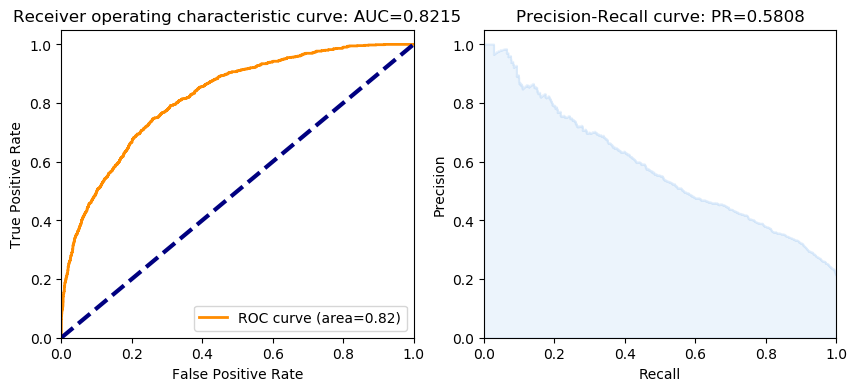

In [75]:
#check the performance using sample data
ROC_AUC(best_gbm,train_sam_hex,'loan_default')

gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



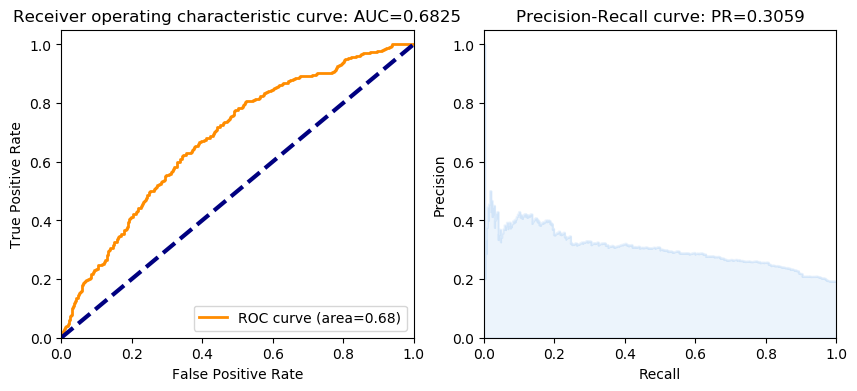

In [76]:
ROC_AUC(best_gbm,valid_sam_hex,'loan_default')

The best model has an AUC score of 0.82 for the train set and of 0.68 for validation set. It is obvious that the best_gbm performed better than previous models.

Let's show the variable importance.

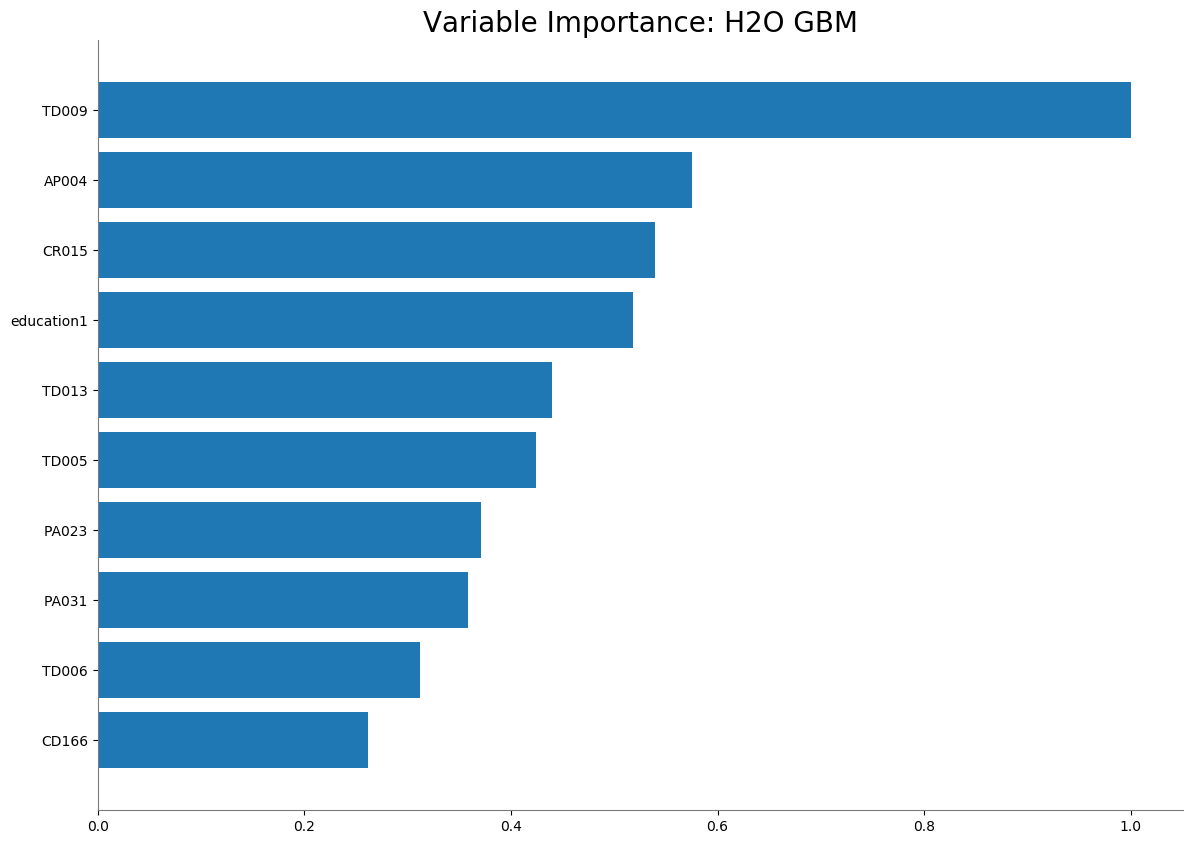

In [68]:
best_gbm.varimp_plot()

###### Now the code works fine with the small dataset, we can model with the entire dataset

In [87]:
best_gbm.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



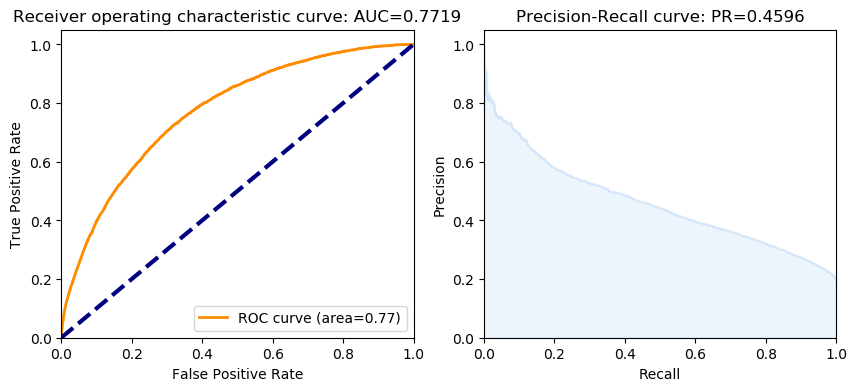

In [88]:
ROC_AUC(best_gbm_whole,train_hex,'loan_default')

In [83]:
createGains(best_gbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,624,976,1600,624,976,0.20,0.08,310.1,2.01,12.0,39.00
1,1600,498,1102,3200,1122,2078,0.36,0.16,620.2,1.81,20.0,35.06
2,1600,419,1181,4800,1541,3259,0.50,0.25,930.3,1.66,25.0,32.10
3,1600,362,1238,6400,1903,4497,0.61,0.35,1240.4,1.53,26.0,29.73
4,1600,306,1294,8000,2209,5791,0.71,0.45,1550.5,1.42,26.0,27.61
5,1600,250,1350,9600,2459,7141,0.79,0.55,1860.6,1.32,24.0,25.61
6,1600,240,1360,11200,2699,8501,0.87,0.66,2170.7,1.24,21.0,24.10
7,1600,167,1433,12800,2866,9934,0.92,0.77,2480.8,1.16,15.0,22.39
8,1600,143,1457,14400,3009,11391,0.97,0.88,2790.9,1.08,9.0,20.90


###### predict test data

In [81]:
##PREDICT test data using best_gbm
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)
GBM_actual_predict = actual_predict(best_gbm,test_hex,target)
GBM_actual_predict.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


,actual,pred
0,0,0.186559
1,0,0.221668
2,0,0.147254
3,0,0.161606
4,0,0.092206


In [93]:
# ROC 
from sklearn.metrics import roc_auc_score
rf_roc_auc_value = roc_auc_score(GBM_actual_predict['actual'],GBM_actual_predict['pred'])
rf_roc_auc_value

0.681681950451801

The AUC score for test data through applying best_gbm is 0.681. 

In [103]:
h2o.shutdown()

H2O session _sid_a4ff closed.
